### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics

### Carregamento de Dados

In [2]:
dataOriginal = pd.read_csv('new_Global_Superstore2.csv', index_col=0, comment='#') 
df = dataOriginal 



# Modelação

## XGBoost

Para utilizarmos XGBoost, temos de converter os dados com "string" para numéricos. 
E removemos colunas que não consideramos importantes.

In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


dataset = df

X = dataset.drop(['Profit'],axis=1)
y = dataset['Profit']

small_dataset = False
if small_dataset: 
    remove_n = 20000
    drop_indices = np.random.choice(dataset.index, remove_n, replace=False)
    dataset_subset = dataset.drop(drop_indices)
    X = dataset_subset.drop('Profit', axis=1)
    y = dataset_subset[['Profit']]


In [4]:


RANDOM_SEED = 2021

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)



In [33]:
def analise_model(model, graph=True): 
    start_time = time.time()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("time - {}".format(time.time()-start_time))
    #predictions  = predictions.reshape(len(predictions),1 )
    # Métricas
    if graph:
        print(model)
        print("Mean Absolute Error: ", mean_absolute_error(y_test, predictions))
        print("Mean Squared Error: ", mean_squared_error(y_test, predictions, squared=True))
    print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    if graph:
        sns.histplot(y_test-predictions, bins=10,stat="density")
        plt.show()
    
        sns.displot(y_test-predictions)
        plt.show() 
        ax = plt.axes()
        ax.plot([-2000, -250, 0, 1500, 3000], [-2000, -250, 0, 1500, 3000], 'r')
        plt.scatter(y_test,predictions)
        plt.show()
    return predictions
    


# Estudar o de baixo
#print(metrics.r2_score(y_test,predictions ))
#df.info()

In [ ]:


xgbModel = xgb.XGBRegressor()

analise_model(xgbModel)



In [12]:
# Veio daqui:
# https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/


def hyper_param(model, params):
    print("Modelo atual: " , model)
    
    # cv = cross-validation generator
    # verbose = quanto é apresentado
    tuning_model=GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=3)
    tuning_model.fit(X_train, y_train)
    
    return tuning_model.best_params_
    

Modelo atual:  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)
Melhores parâmetros:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             en

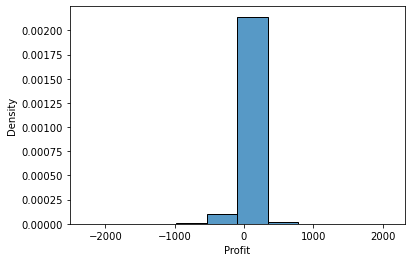

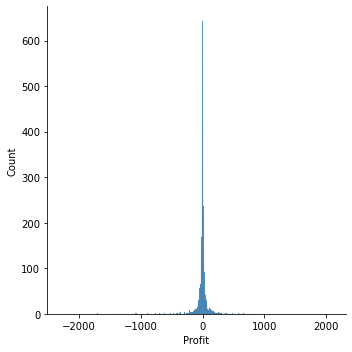

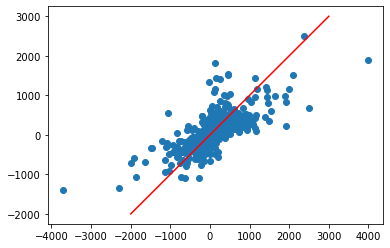

In [13]:
parameters = {
    'max_depth': [2,4,6],
    'n_estimators': [80,100,120],
    'learning_rate': [0.01, 0.1, 0.3]
}

''' Parámetros default, para comparar
{
'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 
'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 
'eval_metric': None, 'feature_types': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 
'importance_type': None, 'interaction_constraints': '', 
'learning_rate': 0.300000012, 

'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 

'max_depth': 6, 

'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 

'n_estimators': 100, 

'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 
'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 
'verbosity': None}
'''


best_param1 = hyper_param(xgbModel, parameters)

best_XGB = xgb.XGBRegressor(random_state=RANDOM_SEED)
print("Melhores parâmetros: ", best_param1)
print(best_XGB.set_params(**best_param1))
predictions = analise_model(best_XGB)

# Análise da coluna objetivo

In [34]:
from sklearn.feature_selection import RFE

for num_cols in range(5,23):
    print("Analise num cols: " , num_cols)
    rfe = RFE(best_XGB, n_features_to_select=num_cols)
    analise_model(rfe, False)

best_num_cols = 20


Analise num cols:  5
time - 41.416077852249146
RMSE:  118.17627317672412
Analise num cols:  6
time - 34.199162006378174
RMSE:  117.8018534154536
Analise num cols:  7
time - 31.904320240020752
RMSE:  115.66463898952034
Analise num cols:  8
time - 34.37749266624451
RMSE:  116.4183649990145
Analise num cols:  9
time - 33.09720540046692
RMSE:  110.52459567071533
Analise num cols:  10
time - 37.29664087295532
RMSE:  111.14068071525348
Analise num cols:  11
time - 27.35859704017639
RMSE:  110.06437453129442
Analise num cols:  12
time - 28.522120237350464
RMSE:  111.26502164397195
Analise num cols:  13
time - 23.208619356155396
RMSE:  111.25485598441159
Analise num cols:  14
time - 24.156521558761597
RMSE:  110.08385753190794
Analise num cols:  15
time - 17.99457025527954
RMSE:  112.5826418446743
Analise num cols:  16
time - 16.918201446533203
RMSE:  112.53900067222034
Analise num cols:  17
time - 15.509914636611938
RMSE:  112.26843901165648
Analise num cols:  18
time - 13.01903510093689
RMSE

In [36]:
from operator import itemgetter


best_num_cols = 9

rfe = RFE(best_XGB, n_features_to_select=best_num_cols)
analise_model(rfe, False)

features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

time - 20.85552716255188
RMSE:  110.52459567071533
1 Ship Mode
1 Country
1 Quantity
1 Shipping_Cost
1 Order_Priority
1 Day_ship
1 pib_country
1 Sub-Category LabelEnc
1 Discount LabelEnc
2 Category LabelEnc
3 Year_order
4 Month_order
5 Month_ship
6 Market
7 Region
8 Day_order
9 City
10 Market_binned
11 State
12 Segment
13 Ship_mode_binned
14 Year_ship


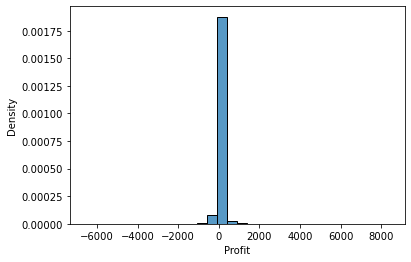

Quartis
[-6599.978      0.         9.2551    36.8415  8399.976 ]


In [38]:
sns.histplot(dataset['Profit'], bins=30,stat="density")
plt.show()
    
print("Quartis")
x = np.quantile(dataset['Profit'], [0,0.25,0.5,0.75,1])

print(x)
#plt.scatter(y_test,predictions)
#plt.show()